In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

Available workers: 16


In [3]:
train_or_load_pretrained = "train" # Set this to "train" if you want to train a new network
pretrained_modelname = "model_time"
num_epochs = 10
batch_size = 32
batch_size_val = 32
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw' #'inception' #wingbeatraw
normalize = ""#"sample"

train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500), RandomRoll(p=1.) ,RandomFlip(), RandomNoise(p=7.)]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500)]


In [4]:
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

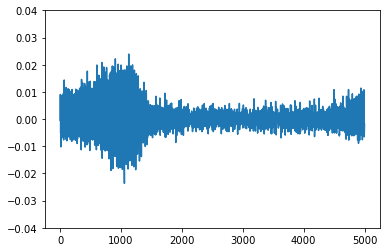

In [5]:
plot_wingbeat(train_dataset, idx=2)

In [6]:
outs = 2
if modeltype == 'wingbeatraw':
    model = DrosophilaNetRAW(outputs=outs, dropout_p=.2)
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=outs))

class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(label_smoothing=0.25)#weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.25)#weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [7]:
if train_or_load_pretrained == 'train':
    # Choosing whether to train on a gpu
    train_on_gpu = torch.cuda.is_available()
    print(f'Train on gpu: {train_on_gpu}')# Number of gpus
    model = model.to('cuda', dtype=torch.float)

    results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
    best_valacc = 0
    # Model training
    for epoch in range(num_epochs):
        # Going through the training set
        correct_train = 0
        model.train()
        for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
            y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
            for param in model.parameters():
                param.grad = None
            pred = model(x_batch)
            if outs == 1:
                y_batch = y_batch.type(torch.FloatTensor).cuda()
                correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
                loss = criterion(pred, y_batch.unsqueeze(1))
            elif outs == 2:
                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
                loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
        train_accuracy = correct_train / len(train_dataset) * 100.

        # Going through the validation set
        correct_valid = 0
        model.eval()
        for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
            pred = model(x_batch)
            if outs == 1:
                y_batch = y_batch.type(torch.FloatTensor).cuda()
                correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
                val_loss = criterion(pred, y_batch.unsqueeze(1))
            elif outs == 2:
                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
                val_loss = criterion(pred, y_batch)
        valid_accuracy = correct_valid / len(valid_dataset) * 100.

        scheduler.step()
    #     early_stopping(val_loss, model)
    #     if early_stopping.early_stop:
    #         print("Early stopping")
    #         break

            # Printing results
        print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")

        is_best = valid_accuracy > best_valacc
        if is_best:
            print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
        best_valacc = max(valid_accuracy, best_valacc)
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_valacc': best_valacc,
            'loss': results['loss'].append(loss.detach().cpu()),
            'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
            'train_accuracy': results['train_accuracy'].append(train_accuracy),
            'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
            'optimizer' : optimizer.state_dict(),
        }, is_best, "model_time")
elif train_or_load_pretrained == 'load':
    model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/{pretrained_modelname}.pth.tar', model, optimizer)
    model = model.to('cuda', dtype=torch.float)
else:
    print("Set train_or_load_pretrained to either \'train\' or \'load\'")

Train on gpu: True


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.20it/s] 


Epoch 0: train_acc: 85.9% loss: 0.5422075,  val_loss: 0.4498796 val_acc: 91.8%
Validation accuracy improved from 0.00 to 91.78. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 86.47it/s] 


Epoch 1: train_acc: 90.4% loss: 0.4279353,  val_loss: 0.4424706 val_acc: 93.5%
Validation accuracy improved from 91.78 to 93.53. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 85.13it/s]


Epoch 2: train_acc: 92.0% loss: 0.6360259,  val_loss: 0.4464855 val_acc: 94.0%
Validation accuracy improved from 93.53 to 94.05. Saving model..


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.22it/s] 


Epoch 3: train_acc: 93.1% loss: 0.4733322,  val_loss: 0.4472784 val_acc: 92.9%


Validating..	: 100%|██████████| 122/122 [00:01<00:00, 95.33it/s] 


Epoch 4: train_acc: 93.7% loss: 0.4563540,  val_loss: 0.3968735 val_acc: 95.6%
Validation accuracy improved from 94.05 to 95.62. Saving model..


Training..	:   1%|          | 5/812 [00:00<01:32,  8.70it/s]


KeyboardInterrupt: 

# MORE LAYERS?

## Testing on test set

In [8]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_time_best.pth.tar', model, optimizer)

In [9]:
model = model.to('cuda', dtype=torch.float)

_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 803/803 [00:06<00:00, 119.04it/s]

Accuracy: 88.23
Balanced accuracy: 87.76
Confusion matrix: 
[[0.79257119 0.20742881]
 [0.03746313 0.96253687]]


## Testing on extra mebios data

In [10]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [11]:
_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 711/711 [00:05<00:00, 120.86it/s]

Accuracy: 93.59
Balanced accuracy: 89.48
Confusion matrix: 
[[0.84897611 0.15102389]
 [0.05942889 0.94057111]]


In [ ]:
def softmax_out(x):
    return np.argmax(F.softmax(x, dim=1), axis=1).tolist()[0]

In [ ]:
from utils import get_all_preds

In [ ]:
df_out = get_all_preds(model, test_dataloader, dataframe=True, final_nodes=2)

In [ ]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
#plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatmain.eps", format='eps', bbox_inches='tight');

In [ ]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize=None)
cm

# ------------------------------------------

In [ ]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')

In [ ]:
m = extra_df[extra_df.y==0].sample(1000)
s = extra_df[extra_df.y==1].sample(1000)
extra_df = pd.concat([m,s]).reset_index(drop=True)

In [ ]:
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [ ]:
df_out = get_all_preds(model, extra_dataloader, dataframe=True, final_nodes=2)

In [ ]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')

sns.set(font_scale=1.9)
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True, fmt='.0%', vmin=0, vmax=1)
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");
#plt.savefig("/home/kalfasyan/Dropbox/kuleuven/paper2_figures/confmatsecondary.eps", format='eps', bbox_inches='tight');

In [ ]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize=None)
cm